# Prediction Lines
Prediction lines to predict trend of data.

In [25]:
# Enable Intellisense
%config IPCompleter.greedy=True

import pandas as pd
import numpy as np
import io
import requests
import seaborn as sns
from matplotlib import pyplot, dates
import plotly.express as px 
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.io as pio
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from datetime import date

# Annoying warning
pd.options.mode.chained_assignment = None  # default='warn'

In [26]:
cumulative_confirmed = pd.read_csv("data/daily_cumulative_confirmed.csv")
last_day = cumulative_confirmed.iloc[-1]['date']
last_day = pd.to_datetime(last_day, format='%Y-%m-%d')
last_day

Timestamp('2020-04-27 00:00:00')

In [27]:
cumulative_confirmed = cumulative_confirmed.iloc[0:21]
cumulative_confirmed['date'] = pd.to_datetime(cumulative_confirmed['date'], format='%Y-%m-%d')
cumulative_confirmed.tail()

,date,cumulative_cases,daily_cases
16,2020-03-23,402,128.0
17,2020-03-24,554,152.0
18,2020-03-25,709,155.0
19,2020-03-26,927,218.0
20,2020-03-27,1170,243.0


Get data until start of lockdown.

**Date since start**

In [28]:
start_date = cumulative_confirmed['date'][0]
start_date

Timestamp('2020-03-05 00:00:00')

In [29]:
cumulative_confirmed['days_since_start'] = cumulative_confirmed['date'].apply(lambda x: (x-start_date).days)
cumulative_confirmed

,date,cumulative_cases,daily_cases,days_since_start
0,2020-03-05,1,1.0,0
1,2020-03-07,2,1.0,2
2,2020-03-08,3,1.0,3
3,2020-03-09,7,4.0,4
4,2020-03-11,13,6.0,6
5,2020-03-12,16,3.0,7
6,2020-03-13,24,8.0,8
7,2020-03-14,38,14.0,9
8,2020-03-15,51,13.0,10
9,2020-03-16,62,11.0,11


## Scipy fit curve

In [30]:
from scipy.optimize import curve_fit

In [31]:
def func(x, a, b, c):
    return a * b ** x + c

Set bounds on `c` so that curve does not produce negative values

In [32]:
arg_bounds = ((-np.inf,-np.inf, 0),(np.inf,np.inf,np.inf))
arg_bounds 

((-inf, -inf, 0), (inf, inf, inf))

In [33]:
xdata = cumulative_confirmed['days_since_start'][0:-2]
ydata = cumulative_confirmed['cumulative_cases'][0:-2]

In [34]:
popt, pcov = curve_fit(func, xdata, ydata, bounds=arg_bounds)

In [35]:
popt

array([3.12643043e+00, 1.31134864e+00, 1.79791140e-14])

In [36]:
last_actual_day = xdata.iloc[-1]
no_predict_days = (last_day - start_date).days - last_actual_day
next_week_list = list(range(last_actual_day +1,last_actual_day+no_predict_days+1))
no_predict_days

33

In [37]:
xdata_pred = xdata.append(pd.Series(next_week_list), ignore_index=True)
y_data_pred = func(xdata_pred, *popt)
# xdata_pred

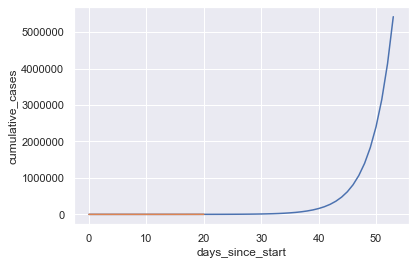

In [38]:
sns.lineplot(xdata_pred, y_data_pred)
sns.lineplot(xdata, ydata)

In [39]:
int_fig = px.line(x=xdata_pred, y=y_data_pred)
int_fig.show()

In [40]:
y_data_pred = y_data_pred.apply(lambda x: round(x))

In [41]:
predict_cum_confirmed = pd.DataFrame(data={'days_since_start':xdata_pred, 'cumulative_cases':y_data_pred})
predict_cum_confirmed

,days_since_start,cumulative_cases
0,0,3
1,2,5
2,3,7
3,4,9
4,6,16
5,7,21
6,8,27
7,9,36
8,10,47
9,11,62


In [42]:
predict_cum_confirmed['date'] = predict_cum_confirmed['days_since_start'].apply(lambda x: start_date + timedelta(days=x))
predict_cum_confirmed

,days_since_start,cumulative_cases,date
0,0,3,2020-03-05
1,2,5,2020-03-07
2,3,7,2020-03-08
3,4,9,2020-03-09
4,6,16,2020-03-11
5,7,21,2020-03-12
6,8,27,2020-03-13
7,9,36,2020-03-14
8,10,47,2020-03-15
9,11,62,2020-03-16


In [43]:
predict_cum_confirmed.set_index('date', inplace=True)
predict_cum_confirmed

,days_since_start,cumulative_cases
date,,
2020-03-05,0,3
2020-03-07,2,5
2020-03-08,3,7
2020-03-09,4,9
2020-03-11,6,16
2020-03-12,7,21
2020-03-13,8,27
2020-03-14,9,36
2020-03-15,10,47


### Daily

In [44]:
predict_cum_daily_confirmed = predict_cum_confirmed.copy()

In [45]:
predict_cum_daily_confirmed['daily_cases'] = predict_cum_daily_confirmed['cumulative_cases'].diff()
predict_cum_daily_confirmed['daily_cases'][0] = predict_cum_daily_confirmed['cumulative_cases'][0]
predict_cum_daily_confirmed

,days_since_start,cumulative_cases,daily_cases
date,,,
2020-03-05,0,3,3.0
2020-03-07,2,5,2.0
2020-03-08,3,7,2.0
2020-03-09,4,9,2.0
2020-03-11,6,16,7.0
2020-03-12,7,21,5.0
2020-03-13,8,27,6.0
2020-03-14,9,36,9.0
2020-03-15,10,47,11.0


In [46]:
predict_cum_daily_confirmed['daily_cases'][18:].pct_change().mean() * 100

31.131542777080455

In [47]:
predict_cum_daily_confirmed['cumulative_cases'][18:].pct_change().mean() * 100

31.134799259106266

In [48]:
predict_cum_daily_confirmed.drop('days_since_start', axis = 1).to_csv('data/predict_confirmed.csv')